## Region Scanning Part 2
Before we subsampled a set of regions and then scanned the sampled data set to find a region of interest. In some cases we might want to scan a set of regions, but with the constraint that some amount of overlap on a range causes the region to be considered inside of that range. We can encode these constraints into the range scanning, but we have to reduce to a point set using a different procedure then before.

In [1]:
import shapefile
import pyscan
import matplotlib.pyplot as plt
import csv
import itertools


def plot_points(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0] )
        ys.append(pt[1])
    ax.scatter(xs, ys, color=c, marker='.')

def plot_points_traj(ax, pts, c):
    xs = []
    ys = []
    for pt in pts:
        xs.append(pt[0])
        ys.append(pt[1])
    ax.plot(xs, ys, color=c)
    
def plot_approx(ax, regions, core_set_pts):
    for reg in regions:
        plot_points_traj(ax, reg, "g")
    plot_points(ax, core_set_pts, "b")
    ax.set_axis_off()


shape = shapefile.Reader("county_shapes/cb_2017_us_county_500k.shp")
population2017 = {}
population2010 = {}

with open("county_population/PEP_2017_PEPANNRES_with_ann.csv", encoding='latin-1') as f:
    reader = csv.DictReader(f)
    headers = next(reader, None)
    for row in reader:
        population2017[row['GEO.id2'][-3:]] = int(row['respop72017'])
        population2010[row['GEO.id2'][-3:]] = int(row['respop72010'])
        
regions = []
weights2017 = []
weights2010 = []
for reg in shape.shapeRecords():
    ignore = False
    for p in reg.shape.points:
        # remove counties outside of the continental US
        if not (-124.84 <= p[0] <= -66.9 and 24.396 <= p[1] <= 49.4):
            ignore = True
            break
    if not ignore:
        weights2010.append(population2010[reg.record[1]]) #reg.record[2], reg.record[5])
        weights2017.append(population2017[reg.record[1]]) #reg.record[2], reg.record[5])
        regions.append([pyscan.Point(p[0], p[1], 1.0) for p in reg.shape.points])
        

Now we use the region simplification code from the region simplification page. We will scan all disks with radii between 24 miles and 240 miles in diameter with an accuracy of 10 miles.

In [2]:
disc_f = pyscan.DISC
alpha = 0.2
r_min = .4
r_max = 4.0

This function scans all the regions defined by the first argument and measures the density of the regions set with the weights "weights2010" and the regions set with the weights "weights2017". Internally it constructs approximations for the regions that alpha spatial error for disks of size r_min to 2 * r_min. It then scans these approximations and repeats with successively larger resolutions.

In [3]:
disk, value = pyscan.max_disk_region(regions, regions, weights2010, regions, weights2017, r_min, r_max, alpha, disc_f)

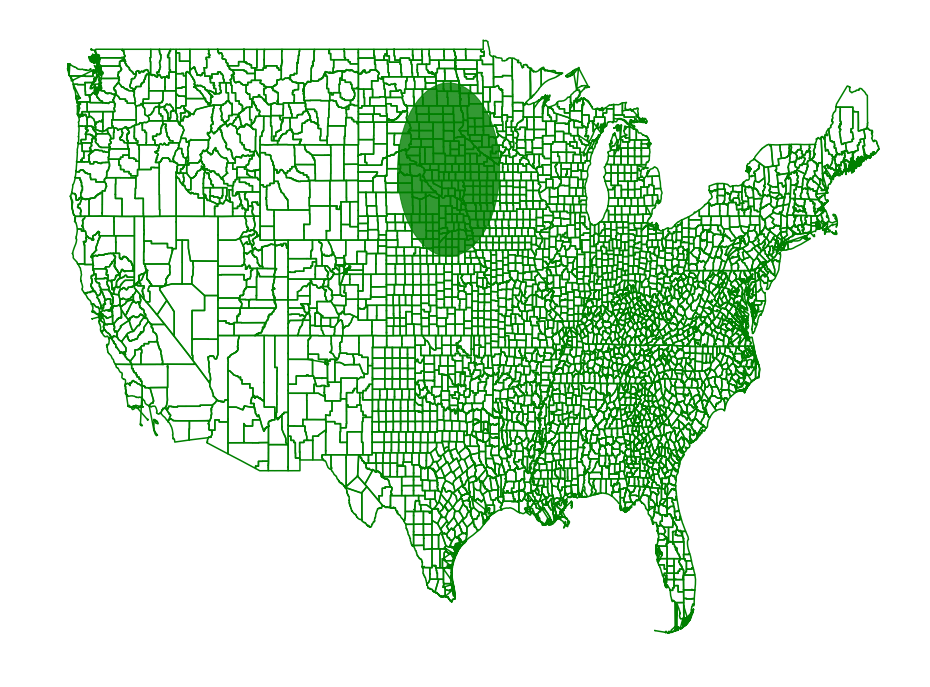

In [4]:
_, ax = plt.subplots(figsize=(16, 12))
plt.axis('off')
plot_approx(ax, regions, [])
d = plt.Circle(disk.get_origin(), disk.get_radius(), color='g', alpha=.8)
ax.add_artist(d)
plt.show()